### Trotterization challenge

This notebook helps you put all your code together-- it implements a loop that computes the staggered magnetization of the spin chain at various time points. Use it to produce plots with your final results.

In [1]:
from src.xyz_evolution_test import XYZEvolutionTestSuite

# Run the TestSuite to make sure everything is working!
tester = XYZEvolutionTestSuite()
tester.run_test_suite()

Uxz test passed!
Uxyz test passed!
XYZ evolution test passed!
XYZ evolution with transverse magnetic field test passed!
Magnetization test passed!
YBE update test passed!
Mirror update test passed!
Circuit compression test passed!


In [2]:
from qiskit_aer import Aer
from qiskit_ionq import IonQProvider

# Get ideal (noiseless) simulator backend
ideal = Aer.get_backend("aer_simulator")

# Set up the IonQ Cloud provider
# Plug in your own API key!
API_KEY = "6oJO91HVKgPtmTFhYbjnZxZ4NQ3lENmm"
provider = IonQProvider(token=API_KEY)

# Request a noisy simulator backend
noisy = provider.get_backend("ionq_simulator")
noisy.options.noise_model = "aria-1"

In [3]:
import numpy as np
from itertools import product
from qiskit import QuantumCircuit

from src.circuit_compressor import CircuitCompressor
from src.staggered_magnetization import StaggeredMagnetization
from src.xyz_evolution import XYZEvolutionCircuit
from tqdm import tqdm

# Define the evolution parameters
num_qubits = 4
J = 3 * np.array([-0.8, 0, -0.2])

# Get a StaggeredMagnetization object
stag_mag = StaggeredMagnetization(num_qubits)

# Construct the Neel initial state
initial_state = QuantumCircuit(num_qubits)
[initial_state.x(j) for j in range(num_qubits) if j % 2]

# Compute staggered magnetization for each time point
num_steps = 11
ms_hist = np.zeros((num_steps, 4))
for n, t in tqdm(enumerate(np.linspace(0, 2.5, num_steps))):
    # Construct the evolution circuit and compress it
    xyz_evolution_qc = XYZEvolutionCircuit(num_qubits, J, 0, t, n)
    compressed_qc = CircuitCompressor(xyz_evolution_qc).compress_circuit()
    
    # Execute circuits circuits on the backend
    for j, (qc, backend) in enumerate(product([xyz_evolution_qc, compressed_qc], [ideal, noisy])):
        qc = initial_state.compose(qc)
        qc.measure_all()
        qc = qc.decompose(["Uxz", "Uxyz"])

        measurements = backend.run(qc, shots=8192).result().get_counts()
        ms_hist[n, j] = stag_mag(measurements)

11it [1:05:41, 358.30s/it]


Now plot your results!

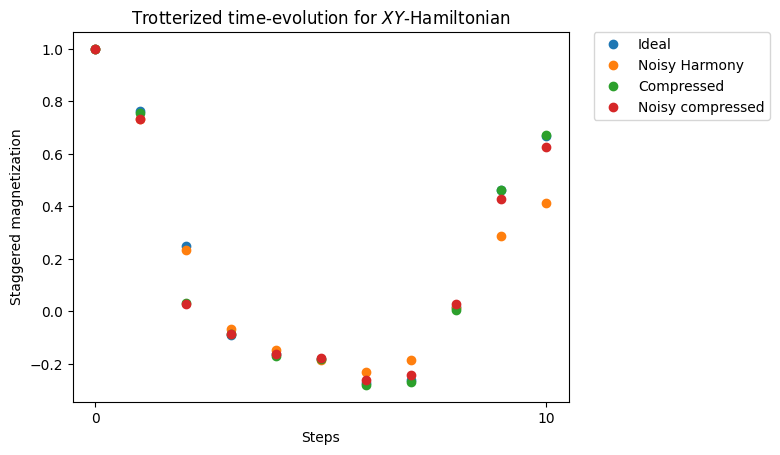

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(ms_hist, "o", label=["Ideal", "Noisy Harmony", "Compressed", "Noisy compressed"])
plt.xticks(np.arange(0, num_steps, 10))
plt.title(r"Trotterized time-evolution for $XY$-Hamiltonian")
plt.ylabel("Staggered magnetization")
plt.xlabel("Steps")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

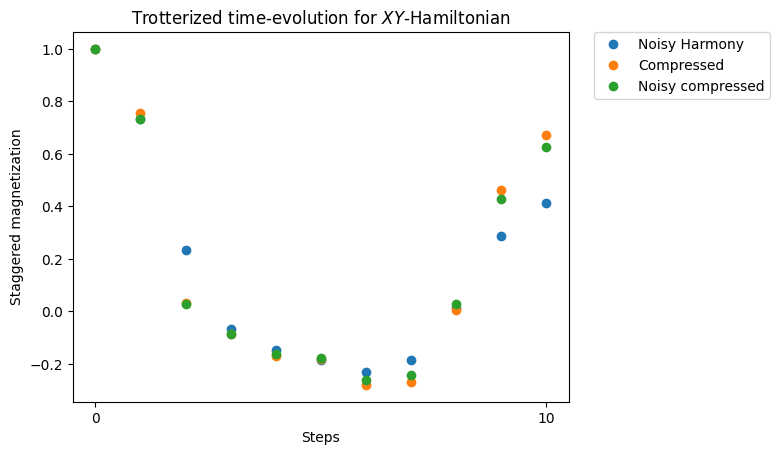

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(ms_hist[:,1:4], "o", label=["Noisy Harmony", "Compressed", "Noisy compressed"])
plt.xticks(np.arange(0, num_steps, 10))
plt.title(r"Trotterized time-evolution for $XY$-Hamiltonian")
plt.ylabel("Staggered magnetization")
plt.xlabel("Steps")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [5]:
# Save your figure!
# fig.savefig(f"{num_qubits}_qubits_compression_example.png")

In [6]:
# Checkout the compressed circuit
qc.draw(fold=-1)

┌────────────┐                                  ┌────────────┐                              ░ ┌─┐         
   q_0: ───────■──┤ Rx(8.0694) ├──■────────────────────────────■──┤ Rx(7.8202) ├──■───────────────────────────░─┤M├─────────
        ┌───┐┌─┴─┐├───────────┬┘┌─┴─┐     ┌────────────┐     ┌─┴─┐├────────────┤┌─┴─┐     ┌────────────┐      ░ └╥┘┌─┐      
   q_1: ┤ X ├┤ X ├┤ Rz(4.589) ├─┤ X ├──■──┤ Rx(6.6068) ├──■──┤ X ├┤ Rz(7.8881) ├┤ X ├──■──┤ Rx(6.2428) ├──■───░──╫─┤M├──────
        └───┘└───┘├───────────┴┐└───┘┌─┴─┐├────────────┤┌─┴─┐└───┘├────────────┤└───┘┌─┴─┐├────────────┤┌─┴─┐ ░  ║ └╥┘┌─┐   
   q_2: ───────■──┤ Rx(4.9278) ├──■──┤ X ├┤ Rz(3.9133) ├┤ X ├──■──┤ Rx(4.6786) ├──■──┤ X ├┤ Rz(2.4133) ├┤ X ├─░──╫──╫─┤M├───
        ┌───┐┌─┴─┐├───────────┬┘┌─┴─┐└───┘└────────────┘└───┘┌─┴─┐├────────────┤┌─┴─┐└───┘└────────────┘└───┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├┤ X ├┤ Rz(4.589) ├─┤ X ├────────────────────────┤ X ├┤ Rz(7.8881) ├┤ X ├─────────────────────────░──╫──╫──╫─┤M├
        └───┘└───┘└───────────┘ └───┘                        └───┘└────────────┘└───┘                         ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                 0  1  2  3